# DNA Feature Viewer

---

Using the `dna_features_viewer` library here: https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer

Preprint - https://www.biorxiv.org/content/10.1101/2020.01.09.900589v1.full.pdf

In [1]:
# pip install dna_features_viewer

In [2]:
# pip install moviepy

In [3]:
# pip install bcbio-gff

---

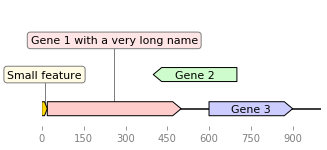

In [17]:
from dna_features_viewer import GraphicFeature, GraphicRecord
features=[
    GraphicFeature(start=0, end=20, strand=+1, color="#ffd700",
                   label="Small feature"),
    GraphicFeature(start=20, end=500, strand=+1, color="#ffcccc",
                   label="Gene 1 with a very long name"),
    GraphicFeature(start=400, end=700, strand=-1, color="#cffccc",
                   label="Gene 2"),
    GraphicFeature(start=600, end=900, strand=+1, color="#ccccff",
                   label="Gene 3")
]
record = GraphicRecord(sequence_length=1000, features=features)
record.plot(figure_width=5);

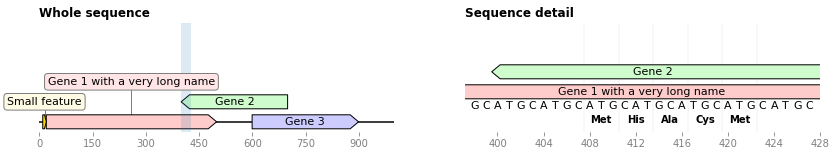

In [2]:
# %load overview_and_detail.py
"""Generate a 2-plot figure with full sequence on the left,
detail of a sub-segment on the right."""

from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.pyplot as plt

record = GraphicRecord(sequence=250 * "ATGC", features=[
    GraphicFeature(start=10, end=20, strand=+1, color="#ffd700",
                   label="Small feature"),
    GraphicFeature(start=20, end=500, strand=+1, color="#ffcccc",
                   label="Gene 1 with a very long name"),
    GraphicFeature(start=400, end=700, strand=-1, color="#cffccc",
                   label="Gene 2"),
    GraphicFeature(start=600, end=900, strand=+1, color="#ccccff",
                   label="Gene 3")
])
zoom_start, zoom_end = 398, 428  # coordinates of the "detail"
cropped_record = record.crop((zoom_start, zoom_end))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 2))

# PLOT THE WHOLE SEQUENCE

ax1.set_title("Whole sequence", loc='left', weight='bold')
record.plot(ax=ax1)
ax1.fill_between((zoom_start, zoom_end), +1000, -1000, alpha=0.15)

# PLOT THE SEQUENCE DETAILS


cropped_record.plot_translation(ax=ax2, location=(408, 423),
                                fontdict={'weight': 'bold'})
cropped_record.plot(ax=ax2, plot_sequence=True)
ax2.set_title("Sequence detail", loc='left', weight='bold')

fig.savefig('overview_and_detail.png', bbox_inches='tight')


In [3]:
# %load from_genbank.py 
from dna_features_viewer import BiopythonTranslator

graphic_record = BiopythonTranslator().translate_record("example_sequence.gb")
ax, _ = graphic_record.plot(figure_width=10, strand_in_label_threshold=7)
ax.figure.tight_layout()
ax.figure.savefig("from_genbank.png")


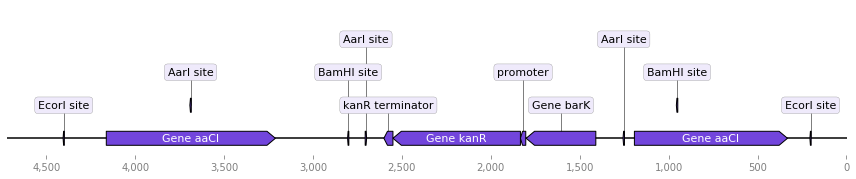

In [5]:
# %load example_with_inverted_x_axis.py
"""This example shows how you can very easily flip a plot horizontally if you
need, using Matplotlib's ax.set_xlim() method."""

from dna_features_viewer import BiopythonTranslator, load_record

ax = BiopythonTranslator.quick_class_plot("example_sequence.gb")
x1, x2 = ax.get_xlim()
ax.set_xlim(x2, x1)
ax.figure.tight_layout()
ax.figure.savefig("example_with_inverted_x_axis.svg")


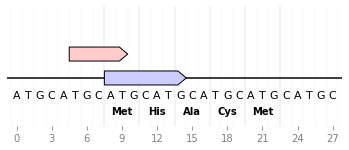

In [4]:
# %load sequence_and_translation.py
from dna_features_viewer import GraphicFeature, GraphicRecord

record = GraphicRecord(sequence="ATGCATGCATGCATGCATGCATGCATGC", features=[
    GraphicFeature(start=5, end=10, strand=+1, color='#ffcccc'),
    GraphicFeature(start=8, end=15, strand=+1, color='#ccccff')
])

ax, _ = record.plot(figure_width=6)
record.plot_sequence(ax, guides_intensity=0.2)
fontdict = {'weight': 'bold'}
record.plot_translation(ax, (8, 23), fontdict=fontdict, guides_intensity=0.8)
ax.figure.savefig('sequence_and_translation.png', bbox_inches='tight')


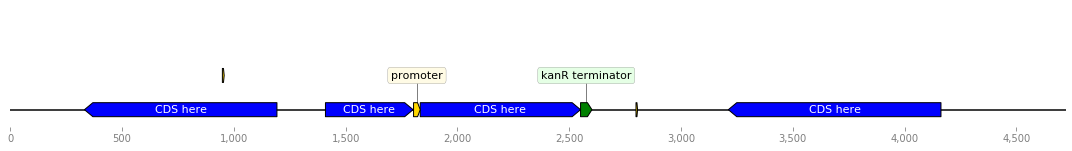

In [6]:
# %load custom_biopython_translator.py
from dna_features_viewer import BiopythonTranslator

class MyCustomTranslator(BiopythonTranslator):
    """Custom translator implementing the following theme:

    - Color terminators in green, CDS in blue, all other features in gold.
    - Do not display features that are restriction sites unless they are BamHI
    - Do not display labels for restriction sites.
    - For CDS labels just write "CDS here" instead of the name of the gene.

    """

    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "blue"
        elif feature.type == "terminator":
            return "green"
        else:
            return "gold"

    def compute_feature_label(self, feature):
        if feature.type == 'restriction_site':
            return None
        elif feature.type == "CDS":
            return "CDS here"
        else:
            return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        """Do not display promoters. Just because."""
        return [
            feature for feature in features
            if (feature.type != "restriction_site")
            or ("BamHI" in str(feature.qualifiers.get("label", '')))
        ]


graphic_record = MyCustomTranslator().translate_record("example_sequence.gb")
ax, _ = graphic_record.plot(figure_width=15)
ax.figure.tight_layout()
ax.figure.savefig("custom_biopython_translator.svg")


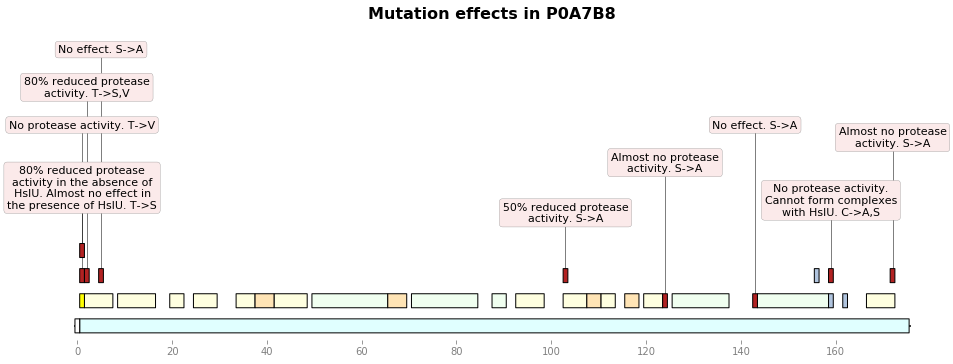

In [7]:
# %load gff_record_from_the_web.py 
import urllib
from io import StringIO
from dna_features_viewer import BiopythonTranslator, load_record

# DEFINE FEATURES ASPECTS


def features_properties(f):
    """Mutations get a red label, other features get a pastel color."""
    label = None
    if f.type == "Mutagenesis":
        label = f.qualifiers["Note"][0]
    color = {
        "Mutagenesis": "firebrick",
        "Active site": "yellow",
        "Beta strand": "lightyellow",
        "Chain": "lightcyan",
        "Helix": "honeydew",
        "Initiator methionine": "white",
        "Metal binding": "lightsteelblue",
        "Turn": "moccasin",
    }.get(f.type, "white")
    return dict(color=color, label=label)


# GET THE RECORD FROM UNIPROT

response = urllib.request.urlopen("https://www.uniprot.org/uniprot/P0A7B8.gff")
record_file = StringIO(response.read().decode())

# TRANSLATE AND PLOT THE RECORD

translator = BiopythonTranslator(features_properties=features_properties)
graphic_record = translator.translate_record(record_file)
ax, _ = graphic_record.plot(
    figure_width=15, max_label_length=100, elevate_outline_annotations=True,
)
ax.set_title("Mutation effects in P0A7B8", fontweight="bold", fontsize=16)
ax.figure.savefig("gff_record_from_the_web.svg", bbox_inches="tight")


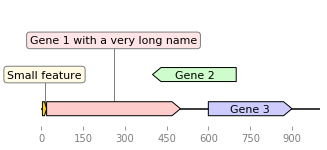

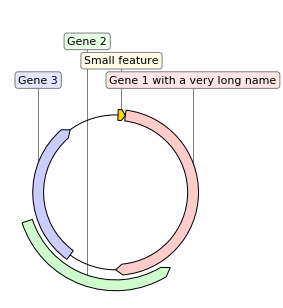

In [8]:
# %load graphic_record_defined_by_hand.py
"""Simple example where a few features are defined "by hand" and are displayed
and exported as PNG, first with a linear view, then with a circular
view.
"""

from dna_features_viewer import (
    GraphicFeature,
    GraphicRecord,
    CircularGraphicRecord,
)

features = [
    GraphicFeature(
        start=5, end=20, strand=+1, color="#ffd700", label="Small feature"
    ),
    GraphicFeature(
        start=20,
        end=500,
        strand=+1,
        color="#ffcccc",
        label="Gene 1 with a very long name",
    ),
    GraphicFeature(
        start=400, end=700, strand=-1, color="#cffccc", label="Gene 2"
    ),
    GraphicFeature(
        start=600, end=900, strand=+1, color="#ccccff", label="Gene 3"
    ),
]


# PLOT AND EXPORT A LINEAR VIEW OF THE CONSTRUCT
record = GraphicRecord(sequence_length=1000, features=features)
ax, _ = record.plot(figure_width=5)
ax.figure.savefig("graphic_record_defined_by_hand.png")


# PLOT AND EXPORT A CIRCULAR VIEW OF THE CONSTRUCT
circular_rec = CircularGraphicRecord(sequence_length=1000, features=features)
ax2, _ = circular_rec.plot(figure_width=4)
ax2.figure.tight_layout()
ax2.figure.savefig(
    "graphic_record_defined_by_hand_circular.png", bbox_inches="tight"
)


In [9]:
# %load locally_highlighted_record.py
from dna_features_viewer import BiopythonTranslator

start, end = 1300, 2700


def feature_properties(f):
    """Fade away all features not overlapping with [start, end]"""
    if f.location.end < start or f.location.start > end:
        return dict(color="white", linecolor="grey", label=None)
    return {}


translator = BiopythonTranslator(features_properties=feature_properties)
graphic_record = translator.translate_record("example_sequence.gb")
ax, _ = graphic_record.plot(figure_width=12, elevate_outline_annotations=True)
ax.fill_between(
    [start, end], -10, 10, facecolor="peachpuff", alpha=0.2, zorder=-1
)

ax.figure.savefig('locally_highlighted_record.png', bbox_inches='tight')


In [11]:
# %load multiline_plot.py
"""In this example we plot a record fragment with sequence over multiple lines.
"""
from dna_features_viewer import BiopythonTranslator

translator = BiopythonTranslator()
graphic_record = translator.translate_record("example_sequence.gb")
subrecord = graphic_record.crop((1700, 2000))
fig, axes = subrecord.plot_on_multiple_lines(
    nucl_per_line=70, plot_sequence=True
)
fig.savefig("multiline_plot.svg")


In [12]:
# %load multipage_plot.py
"""In this example we plot a record fragment with sequence over multiple lines.
"""
from dna_features_viewer import BiopythonTranslator


class CustomTranslator(BiopythonTranslator):
    def compute_feature_color(self, feature):
        return {
            "restriction_site": "yellow",
            "CDS": "orange",
            "promoter": "darkblue",
            "terminator": "lightblue",
        }[feature.type]


translator = CustomTranslator()
graphic_record = translator.translate_record("example_sequence.gb")
subrecord = graphic_record.crop((1800, 2750))
subrecord.plot_on_multiple_pages(
    "multipage_plot.pdf",
    nucl_per_line=70,
    lines_per_page=7,
    plot_sequence=True,
)


In [13]:
# %load plot_with_bokeh.py
"""Simple example with Bokeh output. Requires the Bokeh library installed.
"""

from dna_features_viewer import BiopythonTranslator
from bokeh.resources import CDN
from bokeh.embed import file_html

record = BiopythonTranslator().translate_record(record="example_sequence.gb")
plot = record.plot_with_bokeh(figure_width=8)

with open("plot_with_bokeh.html", "w+") as f:
    f.write(file_html(plot, CDN, "Example Sequence"))


185


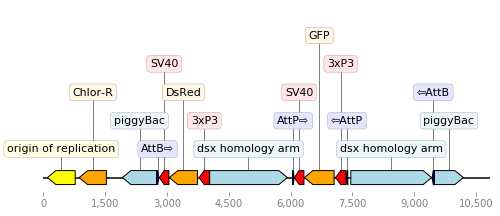

In [14]:
# %load translator_with_cutom_colors.py
"""An example with GIF generation at the end. How cool is that!

This example requires the Moviepy library  installed (pip install moviepy).

"""
from Bio import Entrez, SeqIO
from dna_features_viewer import BiopythonTranslator

# DOWNLOAD THE PLASMID's RECORD FROM NCBI
Entrez.email = "zulko@egf.org"
handle = Entrez.efetch(
    db="nucleotide", id=1473096477, rettype="gb", retmode="text"
)
record = SeqIO.read(handle, "genbank")

# CREATE THE GRAPHIC RECORD WITH DNA_FEATURES_VIEWER

color_map = {
    "rep_origin": "yellow",
    "CDS": "orange",
    "regulatory": "red",
    "misc_recomb": "darkblue",
    "misc_feature": "lightblue",
}
translator = BiopythonTranslator(
    features_filters=(lambda f: f.type not in ["gene", "source"],),
    features_properties=lambda f: {"color": color_map.get(f.type, "white")},
)
translator.max_line_length = 15
graphic_record = translator.translate_record(record)
ax, _ = graphic_record.plot(figure_width=8, strand_in_label_threshold=7)
ax.figure.savefig("translator_with_custom_colors.png", bbox_inches="tight")



In [15]:
# %load with_gc_plot.py
"""In this example we plot a record's annotations on top of the curve of the
local GC content in the record's sequence.
"""
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np


def plot_local_gc_content(record, window_size, ax):
    """Plot windowed GC content on a designated Matplotlib ax."""
    def gc_content(s):
        return 100.0 * len([c for c in s if c in "GC"]) / len(s)

    yy = [
        gc_content(record.seq[i : i + window_size])
        for i in range(len(record.seq) - window_size)
    ]
    xx = np.arange(len(record.seq) - window_size) + 25
    ax.fill_between(xx, yy, alpha=0.3)
    ax.set_ylim(bottom=0)
    ax.set_ylabel("GC(%)")


record = SeqIO.read("example_sequence.gb", "genbank")
translator = BiopythonTranslator()
graphic_record = translator.translate_record(record)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 3), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)
plot_local_gc_content(record, window_size=50, ax=ax2)

fig.tight_layout()  # Resize the figure to the right height
fig.savefig("with_gc_plot.png")


In [19]:
from dna_features_viewer import BiopythonTranslator

from Bio import Entrez
from Bio import SeqIO

sequences = []

Entrez.email = "richard.squires@nih.gov"
identifiers = ["U94848.1"]

with Entrez.efetch( db="nucleotide", rettype="gb", retmode="text", id=identifiers) as handle:
    for seq_record in SeqIO.parse(handle, "gb"):
        sequences.append(seq_record)

count = SeqIO.write(sequences, "U94848.1.gb", "gb")
print("Save {} sequences to a file".format(count))

Save 1 sequences to a file


In [16]:
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator implementing the following theme:

    - Color terminators in green, CDS in blue, all other features in gold.
    - Do not display features that are restriction sites unless they are BamHI
    - Do not display labels for restriction sites.
    - For CDS labels just write "CDS here" instead of the name of the gene.

    """

    def compute_feature_color(self, feature):
        if feature.type == "gene":
            return "blue"
        elif feature.type == "terminator":
            return "green"
        else:
            return "gold"

    def compute_feature_label(self, feature):
        if feature.type == 'restriction_site':
            return None
        elif feature.type == "CDS":
            return "CDS"
        else:
            return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        """Do not display promoters. Just because."""
        return [
            feature for feature in features
            if (feature.type != "restriction_site")
            or ("BamHI" in str(feature.qualifiers.get("label", '')))
        ]


graphic_record = MyCustomTranslator().translate_record("U94848.1.gb")
ax, _ = graphic_record.plot(figure_width=100)
ax.figure.tight_layout()
ax.figure.savefig("U94848.1.svg")

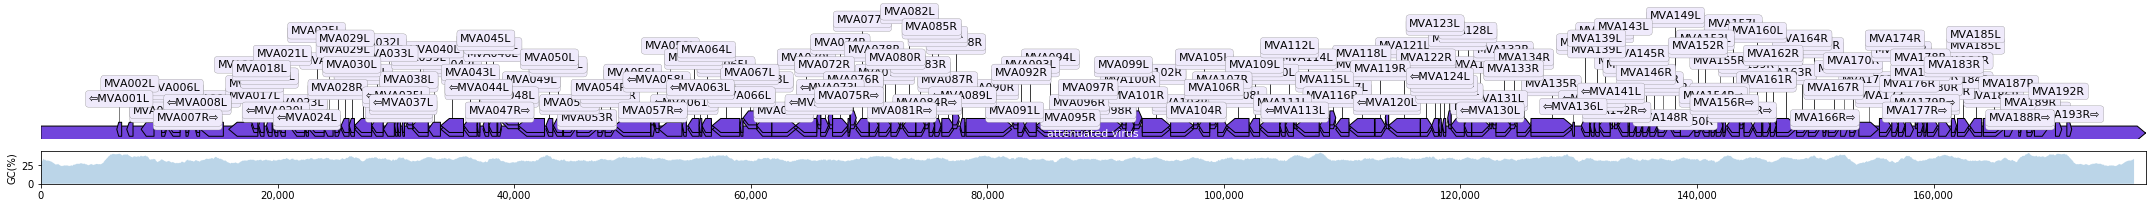

In [17]:
"""In this example we plot a record's annotations on top of the curve of the
local GC content in the record's sequence.
"""
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np


def plot_local_gc_content(record, window_size, ax):
    """Plot windowed GC content on a designated Matplotlib ax."""
    def gc_content(s):
        return 100.0 * len([c for c in s if c in "GC"]) / len(s)

    yy = [
        gc_content(record.seq[i : i + window_size])
        for i in range(len(record.seq) - window_size)
    ]
    xx = np.arange(len(record.seq) - window_size) + 25
    ax.fill_between(xx, yy, alpha=0.3)
    ax.set_ylim(bottom=0)
    ax.set_ylabel("GC(%)")


record = SeqIO.read("U94848.1.gb", "gb")
translator = BiopythonTranslator()
graphic_record = translator.translate_record(record)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(30, 3), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)
plot_local_gc_content(record, window_size=1000, ax=ax2)

fig.tight_layout()  # Resize the figure to the right height
fig.savefig("with_gc_plot.svg")

In [18]:
"""An example with GIF generation at the end. How cool is that!

This example requires the Moviepy library  installed (pip install moviepy).

"""
from Bio import Entrez, SeqIO
import moviepy.editor as mpe
from moviepy.video.io.bindings import mplfig_to_npimage
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator, CircularGraphicRecord

# DOWNLOAD THE PLASMID's RECORD FROM NCBI

handle = Entrez.efetch(
    db="nucleotide", id=1473096477, rettype="gb", retmode="text"
)
record = SeqIO.read(handle, "genbank")

# CREATE THE GRAPHIC RECORD WITH DNA_FEATURES_VIEWER

color_map = {
    "rep_origin": "yellow",
    "CDS": "orange",
    "regulatory": "red",
    "misc_recomb": "darkblue",
    "misc_feature": "lightblue",
}
translator = BiopythonTranslator(
    features_filters=(lambda f: f.type not in ["gene", "source"],),
    features_properties=lambda f: {"color": color_map.get(f.type, "white")},
)
translator.max_line_length = 15
graphic_record = translator.translate_record(
    record, record_class=CircularGraphicRecord
)
graphic_record.labels_spacing = 15

# ANIMATE INTO A GIF WITH MOVIEPY

duration = 5


def make_frame(t):
    top_nucleotide_index = t * graphic_record.sequence_length / duration
    graphic_record.top_position = top_nucleotide_index
    ax, _ = graphic_record.plot(figure_width=8, figure_height=11)
    ax.set_ylim(top=2)
    np_image = mplfig_to_npimage(ax.figure)
    plt.close(ax.figure)
    return np_image


clip = mpe.VideoClip(make_frame, duration=duration)
small_clip = clip.crop(x1=60, x2=-60, y1=100, y2=-100).resize(0.5)
small_clip.write_gif("example_with_gif.gif", fps=15)

t:   3%|▎         | 2/75 [00:00<00:04, 15.50it/s, now=None]

MoviePy - Building file example_with_gif.gif with imageio.


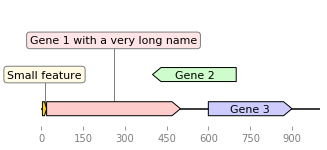

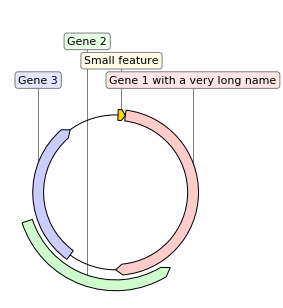

In [23]:
"""Simple example where a few features are defined "by hand" and are displayed
and exported as PNG, first with a linear view, then with a circular
view.
"""

from dna_features_viewer import (
    GraphicFeature,
    GraphicRecord,
    CircularGraphicRecord,
)

features = [
    GraphicFeature(
        start=5, end=20, strand=+1, color="#ffd700", label="Small feature"
    ),
    GraphicFeature(
        start=20,
        end=500,
        strand=+1,
        color="#ffcccc",
        label="Gene 1 with a very long name",
    ),
    GraphicFeature(
        start=400, end=700, strand=-1, color="#cffccc", label="Gene 2"
    ),
    GraphicFeature(
        start=600, end=900, strand=+1, color="#ccccff", label="Gene 3"
    ),
]


# PLOT AND EXPORT A LINEAR VIEW OF THE CONSTRUCT
record = GraphicRecord(sequence_length=1000, features=features)
ax, _ = record.plot(figure_width=5)
ax.figure.savefig("graphic_record_defined_by_hand.png")


# PLOT AND EXPORT A CIRCULAR VIEW OF THE CONSTRUCT
circular_rec = CircularGraphicRecord(sequence_length=1000, features=features)
ax2, _ = circular_rec.plot(figure_width=4)
ax2.figure.tight_layout()
ax2.figure.savefig(
    "graphic_record_defined_by_hand_circular.png", bbox_inches="tight"
)

In [24]:
# %load example_with_gif.py
"""An example with GIF generation at the end. How cool is that!

This example requires the Moviepy library  installed (pip install moviepy).

"""
from Bio import Entrez, SeqIO
import moviepy.editor as mpe
from moviepy.video.io.bindings import mplfig_to_npimage
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator, CircularGraphicRecord

# DOWNLOAD THE PLASMID's RECORD FROM NCBI

handle = Entrez.efetch(
    db="nucleotide", id=1473096477, rettype="gb", retmode="text"
)
record = SeqIO.read(handle, "genbank")

# CREATE THE GRAPHIC RECORD WITH DNA_FEATURES_VIEWER

color_map = {
    "rep_origin": "yellow",
    "CDS": "orange",
    "regulatory": "red",
    "misc_recomb": "darkblue",
    "misc_feature": "lightblue",
}
translator = BiopythonTranslator(
    features_filters=(lambda f: f.type not in ["gene", "source"],),
    features_properties=lambda f: {"color": color_map.get(f.type, "white")},
)
translator.max_line_length = 15
graphic_record = translator.translate_record(
    record, record_class=CircularGraphicRecord
)
graphic_record.labels_spacing = 15

# ANIMATE INTO A GIF WITH MOVIEPY

duration = 5


def make_frame(t):
    top_nucleotide_index = t * graphic_record.sequence_length / duration
    graphic_record.top_position = top_nucleotide_index
    ax, _ = graphic_record.plot(figure_width=8, figure_height=11)
    ax.set_ylim(top=2)
    np_image = mplfig_to_npimage(ax.figure)
    plt.close(ax.figure)
    return np_image


clip = mpe.VideoClip(make_frame, duration=duration)
small_clip = clip.crop(x1=60, x2=-60, y1=100, y2=-100).resize(0.5)
small_clip.write_gif("example_with_gif.gif", fps=15)

t:   4%|▍         | 3/75 [00:00<00:04, 17.40it/s, now=None]

MoviePy - Building file example_with_gif.gif with imageio.


In [25]:
# %load cartoon_style.py